<a href="https://colab.research.google.com/github/sun9huni/first-repository/blob/main/%EB%8D%B0%EC%8B%B84%EA%B8%B0_%EA%B9%80%EC%84%B1%ED%9B%88_%ED%9A%8C%EA%B7%80_%EC%A7%91%EA%B0%92%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle= True)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
rf_params = {'n_estimators': [100, 200, 500]}
gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,force_col_wise=True), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0), {}, X_features, y_target)


# 개별 모델 학습 및 예측
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)

models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # Add other models if used
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)


Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # Add other model's train data
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # Add other model's test data

meta_model_lasso = Lasso(alpha=0.0005)
meta_model_lasso.fit(Stack_final_X_train, y_train)
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 테스트 데이터 전처리 및 예측
test_df = pd.read_csv('./test.csv')
test_df_ohe, _ = preprocess_data(test_df.copy()) # Use copy to avoid modifying original test_df

# Ensure test set has the same columns as the training set after one-hot encoding
test_df_ohe = test_df_ohe.reindex(columns=X_features.columns, fill_value=0)

# 개별 모델 또는 스태킹 모델을 사용하여 예측
# 여기서는 스태킹 모델을 사용합니다.
final_test_pred = meta_model_lasso.predict(np.concatenate((
    get_stacking_base_datasets(ridge_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(lasso_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(xgb_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(lgbm_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1]
    # Add other models test predictions
), axis=1))

# 예측값 복원
final_test_pred_exp = np.expm1(final_test_pred)

# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission.csv", index=False)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.125, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.020049
[LightGBM] [Warning] Found wh

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle= True)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
rf_params = {'n_estimators': [100, 200, 500]}
gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0), {}, X_features, y_target)


# 개별 모델 학습 및 예측
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)

models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # Add other models if used
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)


Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # Add other model's train data
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # Add other model's test data

meta_model_lasso = Lasso(alpha=0.0005)
meta_model_lasso.fit(Stack_final_X_train, y_train)
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 테스트 데이터 전처리 및 예측
test_df = pd.read_csv('./test.csv')
test_df_ohe, _ = preprocess_data(test_df.copy()) # Use copy to avoid modifying original test_df

# Ensure test set has the same columns as the training set after one-hot encoding
test_df_ohe = test_df_ohe.reindex(columns=X_features.columns, fill_value=0)

# 개별 모델 또는 스태킹 모델을 사용하여 예측
# 여기서는 스태킹 모델을 사용합니다.
final_test_pred = meta_model_lasso.predict(np.concatenate((
    get_stacking_base_datasets(ridge_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(lasso_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(xgb_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1],
    get_stacking_base_datasets(lgbm_reg, X_features.values, y_target.values, test_df_ohe.values, 5)[1]
    # Add other models test predictions
), axis=1))

# 예측값 복원
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)

# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission.csv", index=False)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.125, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00
데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyl

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal,122900



'SalePrice' 분포 시각화:


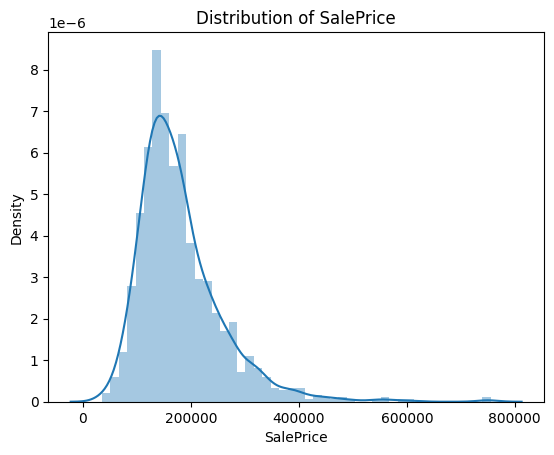

ValueError: could not convert string to float: 'RL'

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# # 주택 가격 예측 프로젝트
# 캘리포니아의 주택 가격 데이터를 사용하여 다양한 회귀 모델을 구축하고, 스태킹 앙상블 기법을 적용하여 예측 성능을 개선
# ## 1. 데이터 이해 및 탐색
#
# 데이터셋은 주택의 다양한 features와 해당 주택의 판매 가격(SalePrice)으로 구성. 예측 대상은 'SalePrice'

# Install catboost
!pip install catboost

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

# 데이터 로드
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()

print("데이터셋 정보:")
house_df.info()

print("\n데이터셋 상위 5행:")
display(house_df.head())

print("\n'SalePrice' 분포 시각화:")
sns.distplot(house_df['SalePrice'])
plt.title('Distribution of SalePrice')
plt.show()

# 숫자형 피처의 상관관계 시각화 (heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(house_df.corr(), cmap='RdBu_r', annot=False)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# 'SalePrice'와 상관관계가 높은 피처 시각화 (산점도)
high_corr_features = house_df.corr()['SalePrice'].sort_values(ascending=False).index[1:10]
sns.pairplot(house_df[high_corr_features.tolist() + ['SalePrice']], size=2)
plt.suptitle('Pairplot of Features Highly Correlated with SalePrice', y=1.02)
plt.show()


# 결측치 확인
print("\n컬럼별 결측치 개수:")
print(house_df.isnull().sum().sort_values(ascending=False).head(20))


# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    # 원본 데이터에서 제거할 컬럼 목록 정의
    drop_cols = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
    # 데이터프레임에 해당 컬럼이 존재하는 경우에만 삭제
    existing_cols_to_drop = [col for col in drop_cols if col in df.columns]
    if existing_cols_to_drop:
        df.drop(existing_cols_to_drop, axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    # 숫자형 컬럼만 선택
    features_index = df.select_dtypes(include=np.number).columns
    # 대상 컬럼에서 'SalePrice' 제외 (타겟 변수는 전처리 함수에서 변환하지 않음)
    features_for_skew = [col for col in features_index if col != 'SalePrice']
    skew_features = df[features_for_skew].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # 로그 변환 적용
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=156) # random_state 추가
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

# ## 2. 데이터 전처리 과정
#
# 모델 학습 전에 데이터를 정제하고 모델이 학습하기 쉬운 형태로 변환
#
# 1.  **불필요한 컬럼 제거:** 'Id'와 결측치가 너무 많은 일부 컬럼 ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu')을 제거합니다.
# 2.  **결측치 처리:** 숫자형 컬럼의 결측치는 해당 컬럼의 평균값으로 대체
# 3.  **이상치 처리:** 'GrLivArea'와 'SalePrice'의 관계를 시각적으로 확인한 결과, 일부 극단적인 이상치들이 발견해서 제거
# 4.  **피처 엔지니어링 - Skewness 변환:** 데이터의 분포가 한쪽으로 치우쳐(skewed) 있는 피처들은 모델의 예측 성능을 저하시킬 수 있습니다. Skewness가 높은 숫자형 피처들에 `np.log1p` (log(1+x)) 변환을 적용하여 분포를 정규화
# 5.  **카테고리형 피처 인코딩:** 문자열 형태의 카테고리형 피처는 모델이 직접 처리할 수 없으므로, 원-핫 인코딩(`pd.get_dummies`)을 사용하여 숫자형 형태로 변환.

# %%
# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
# 로그 변환된 GrLivArea와 SalePrice를 기준으로 이상치 인덱스를 찾기
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

print("\n전처리 후 데이터셋 shape:", house_df_ohe.shape)


# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

print("\n학습 데이터 shape:", X_train.shape)
print("검증 데이터 shape:", X_test.shape)
print("학습 타겟 shape:", y_train.shape)
print("검증 타겟 shape:", y_test.shape)

# ## 3. 모델 선택 및 비교
#
# 회귀 모델들을 사용 및 성능을 비교
#
# 1.  **Ridge 회귀:** L2 규제를 사용하는 선형 회귀 모델입니다. 다중 공선성 문제를 완화하고 모델의 복잡성을 줄이는 데 효과적입니다.
# 2.  **Lasso 회귀:** L1 규제를 사용하는 선형 회귀 모델입니다. 피처 선택 효과가 있어 중요하지 않은 피처의 계수를 0으로 만들어 모델을 더 간결하게 만듭니다.
# 3.  **XGBoost (Extreme Gradient Boosting):** 강력한 부스팅 기반 앙상블 모델입니다. 뛰어난 예측 성능으로 다양한 데이터 과학 경연 대회에서 우수한 성적을 보여줍니다.
# 4.  **LightGBM (Light Gradient Boosting Machine):** XGBoost와 유사한 부스팅 모델이지만, 학습 속도가 빠르고 메모리 사용량이 적다는 장점이 있습니다. 대용량 데이터에 특히 효과적입니다.
# 5.  **스태킹 앙상블:** 여러 개별 모델의 예측 결과를 다시 학습 데이터로 사용하여 최종 메타 모델을 학습하는 기법입니다. 각 모델의 장점을 결합하여 개별 모델보다 더 나은 예측 성능을 기대할 수 있습니다. 여기서는 개별 모델들의 예측 결과를 기반으로 Lasso 회귀 모델을 메타 모델로 사용합니다.
#
# 각 모델은 고유한 특성을 가지고 있으며, 데이터의 특성에 따라 성능 차이, 여러 모델을 비교해 데이터에 가장 적합한 모델을 찾고, 스태킹을 통해 모델들의 시너지를 활용

# %%
# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
rf_params = {'n_estimators': [100, 200, 500]}
gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
rf_reg = RandomForestRegressor(**best_rf.get_params())
gb_reg = GradientBoostingRegressor(**best_gb.get_params())
cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)
gb_reg.fit(X_train, y_train)
cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# ## 4. 성능평가
#
# 모델의 성능은 검증 데이터셋에 대한 RMSE (Root Mean Squared Error) 지표를 사용하여 평가합, RMSE는 예측값과 실제값의 차이를 제곱하여 평균한 값에 루트를 씌운 것으로, 오류의 크기를 나타냅니다. 값이 작을수록 모델의 예측 성능이 우수함을 의미합니다. 특히 타겟 변수가 로그 변환되었으므로, 최종 RMSE는 `np.expm1`을 적용하여 원래 스케일로 복원된 값에 대해 계산합니다.
#
# 하이퍼파라미터 튜닝은 `GridSearchCV`를 사용하여 수행했습니다. 각 모델별로 주요 하이퍼파라미터 그리드를 정의하고, 5-Fold Cross Validation을 통해 최적의 파라미터 조합을 찾았습니다. Grid Search 과정에서 각 파라미터 조합에 대한 교차 검증 평균 RMSE 값을 기록하고, 가장 낮은 RMSE를 보인 파라미터를 최종 모델에 적용했습니다.
#
# 스태킹 앙상블의 경우, KFold 교차 검증을 통해 개별 기반 모델들의 예측 결과를 생성하고, 이 결과를 학습 데이터로 사용하여 최종 메타 모델(Lasso)을 학습시켰습니다. 메타 모델은 개별 모델들의 예측 결과를 바탕으로 최종 예측을 수행하며, 이 예측값 또한 RMSE로 평가됩니다.

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

print("\n스태킹 학습 데이터 shape:", Stack_final_X_train.shape)
print("스태킹 테스트 데이터 shape:", Stack_final_X_test.shape)


# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
# 스태킹 테스트 데이터 예측 결과에 대해 y_test (로그 변환된 실제값)와의 RMSE를 계산합니다.
# get_rmse 함수는 내부적으로 np.expm1을 적용하여 RMSE를 계산합니다.
print('\n스태킹 회귀 모델 성능 평가:')
get_rmse(meta_model_lasso, Stack_final_X_test, y_test)


# 제출용 Test 데이터 전처리 및 예측
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
drop_cols_test = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
existing_cols_to_drop_test = [col for col in drop_cols_test if col in test_df.columns]
if existing_cols_to_drop_test:
    test_df.drop(existing_cols_to_drop_test, axis=1 , inplace=True)


# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index는 학습 데이터에서 계산된 skewness가 높은 피처 인덱스입니다.
# Test 데이터에는 'SalePrice' 컬럼이 없으므로 skew_features_top_index 전체를 사용합니다.
# 하지만 preprocess_data 함수에서 이미 'SalePrice'를 제외하고 skewness를 계산했으므로 이 부분은 문제 없다.
# Test 데이터에만 존재하는 컬럼이 skew_features_top_index에 포함될 일은 없지만, 안전을 위해 확인합니다.
skew_cols_for_test = [col for col in skew_features_top_index if col in test_df.columns]
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
# 학습 데이터에 없던 컬럼은 0으로 채우고, 테스트 데이터에 없던 컬럼은 삭제합니다.
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values # 전체 학습 데이터의 타겟값
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
# 메타 모델은 전체 학습 데이터로 학습된 상태입니다.
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal,122900



'SalePrice' 분포 시각화:


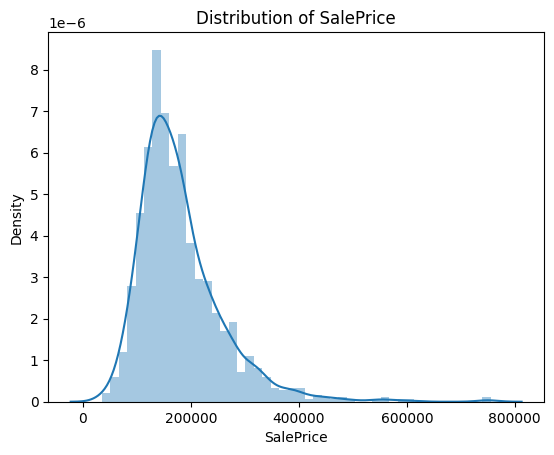


컬럼별 결측치 개수:
PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageQual        69
GarageFinish      69
GarageType        69
GarageYrBlt       69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtCond          23
BsmtQual          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

전처리 후 데이터셋 shape: (1168, 267)

학습 데이터 shape: (934, 266)
검증 데이터 shape: (234, 266)
학습 타겟 shape: (934,)
검증 타겟 shape: (234,)

전처리 후 숫자형 피처의 상관관계 시각화 (heatmap):


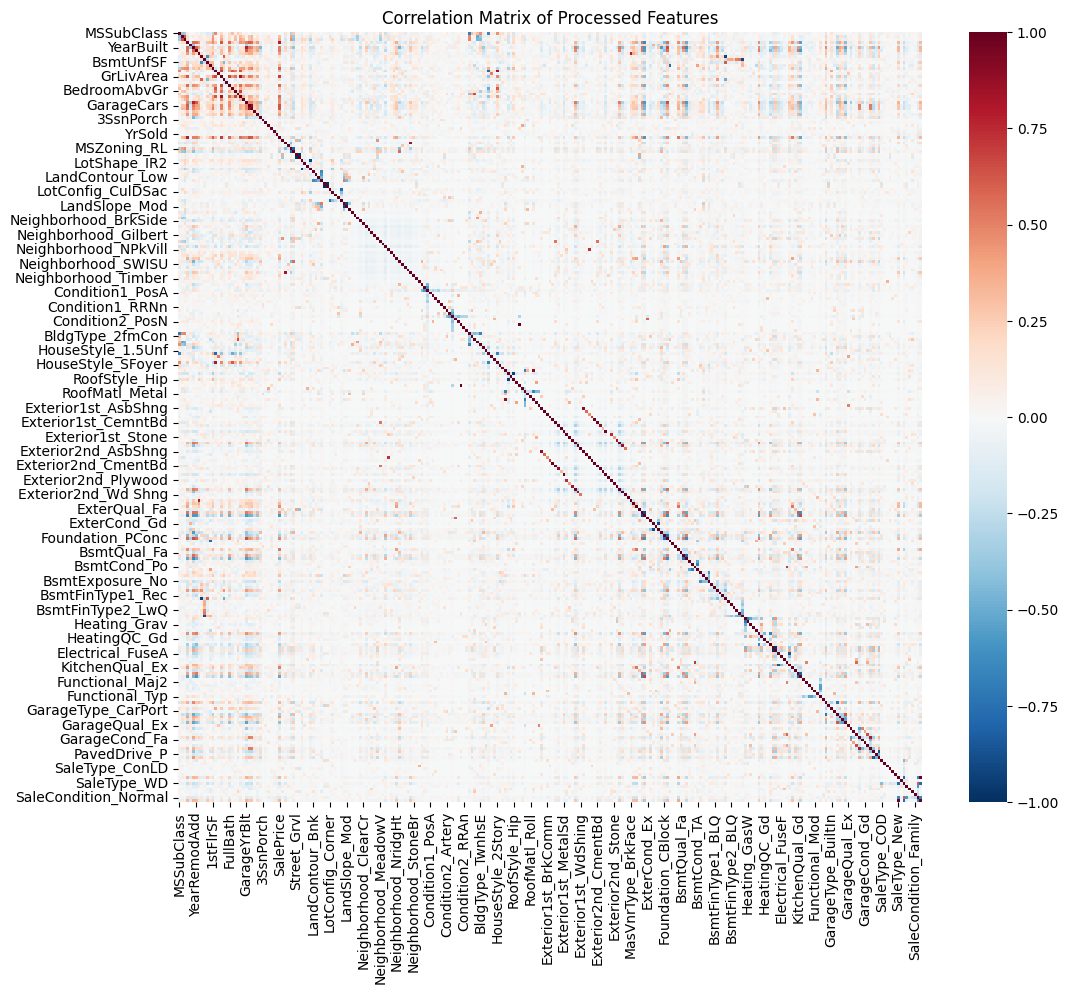

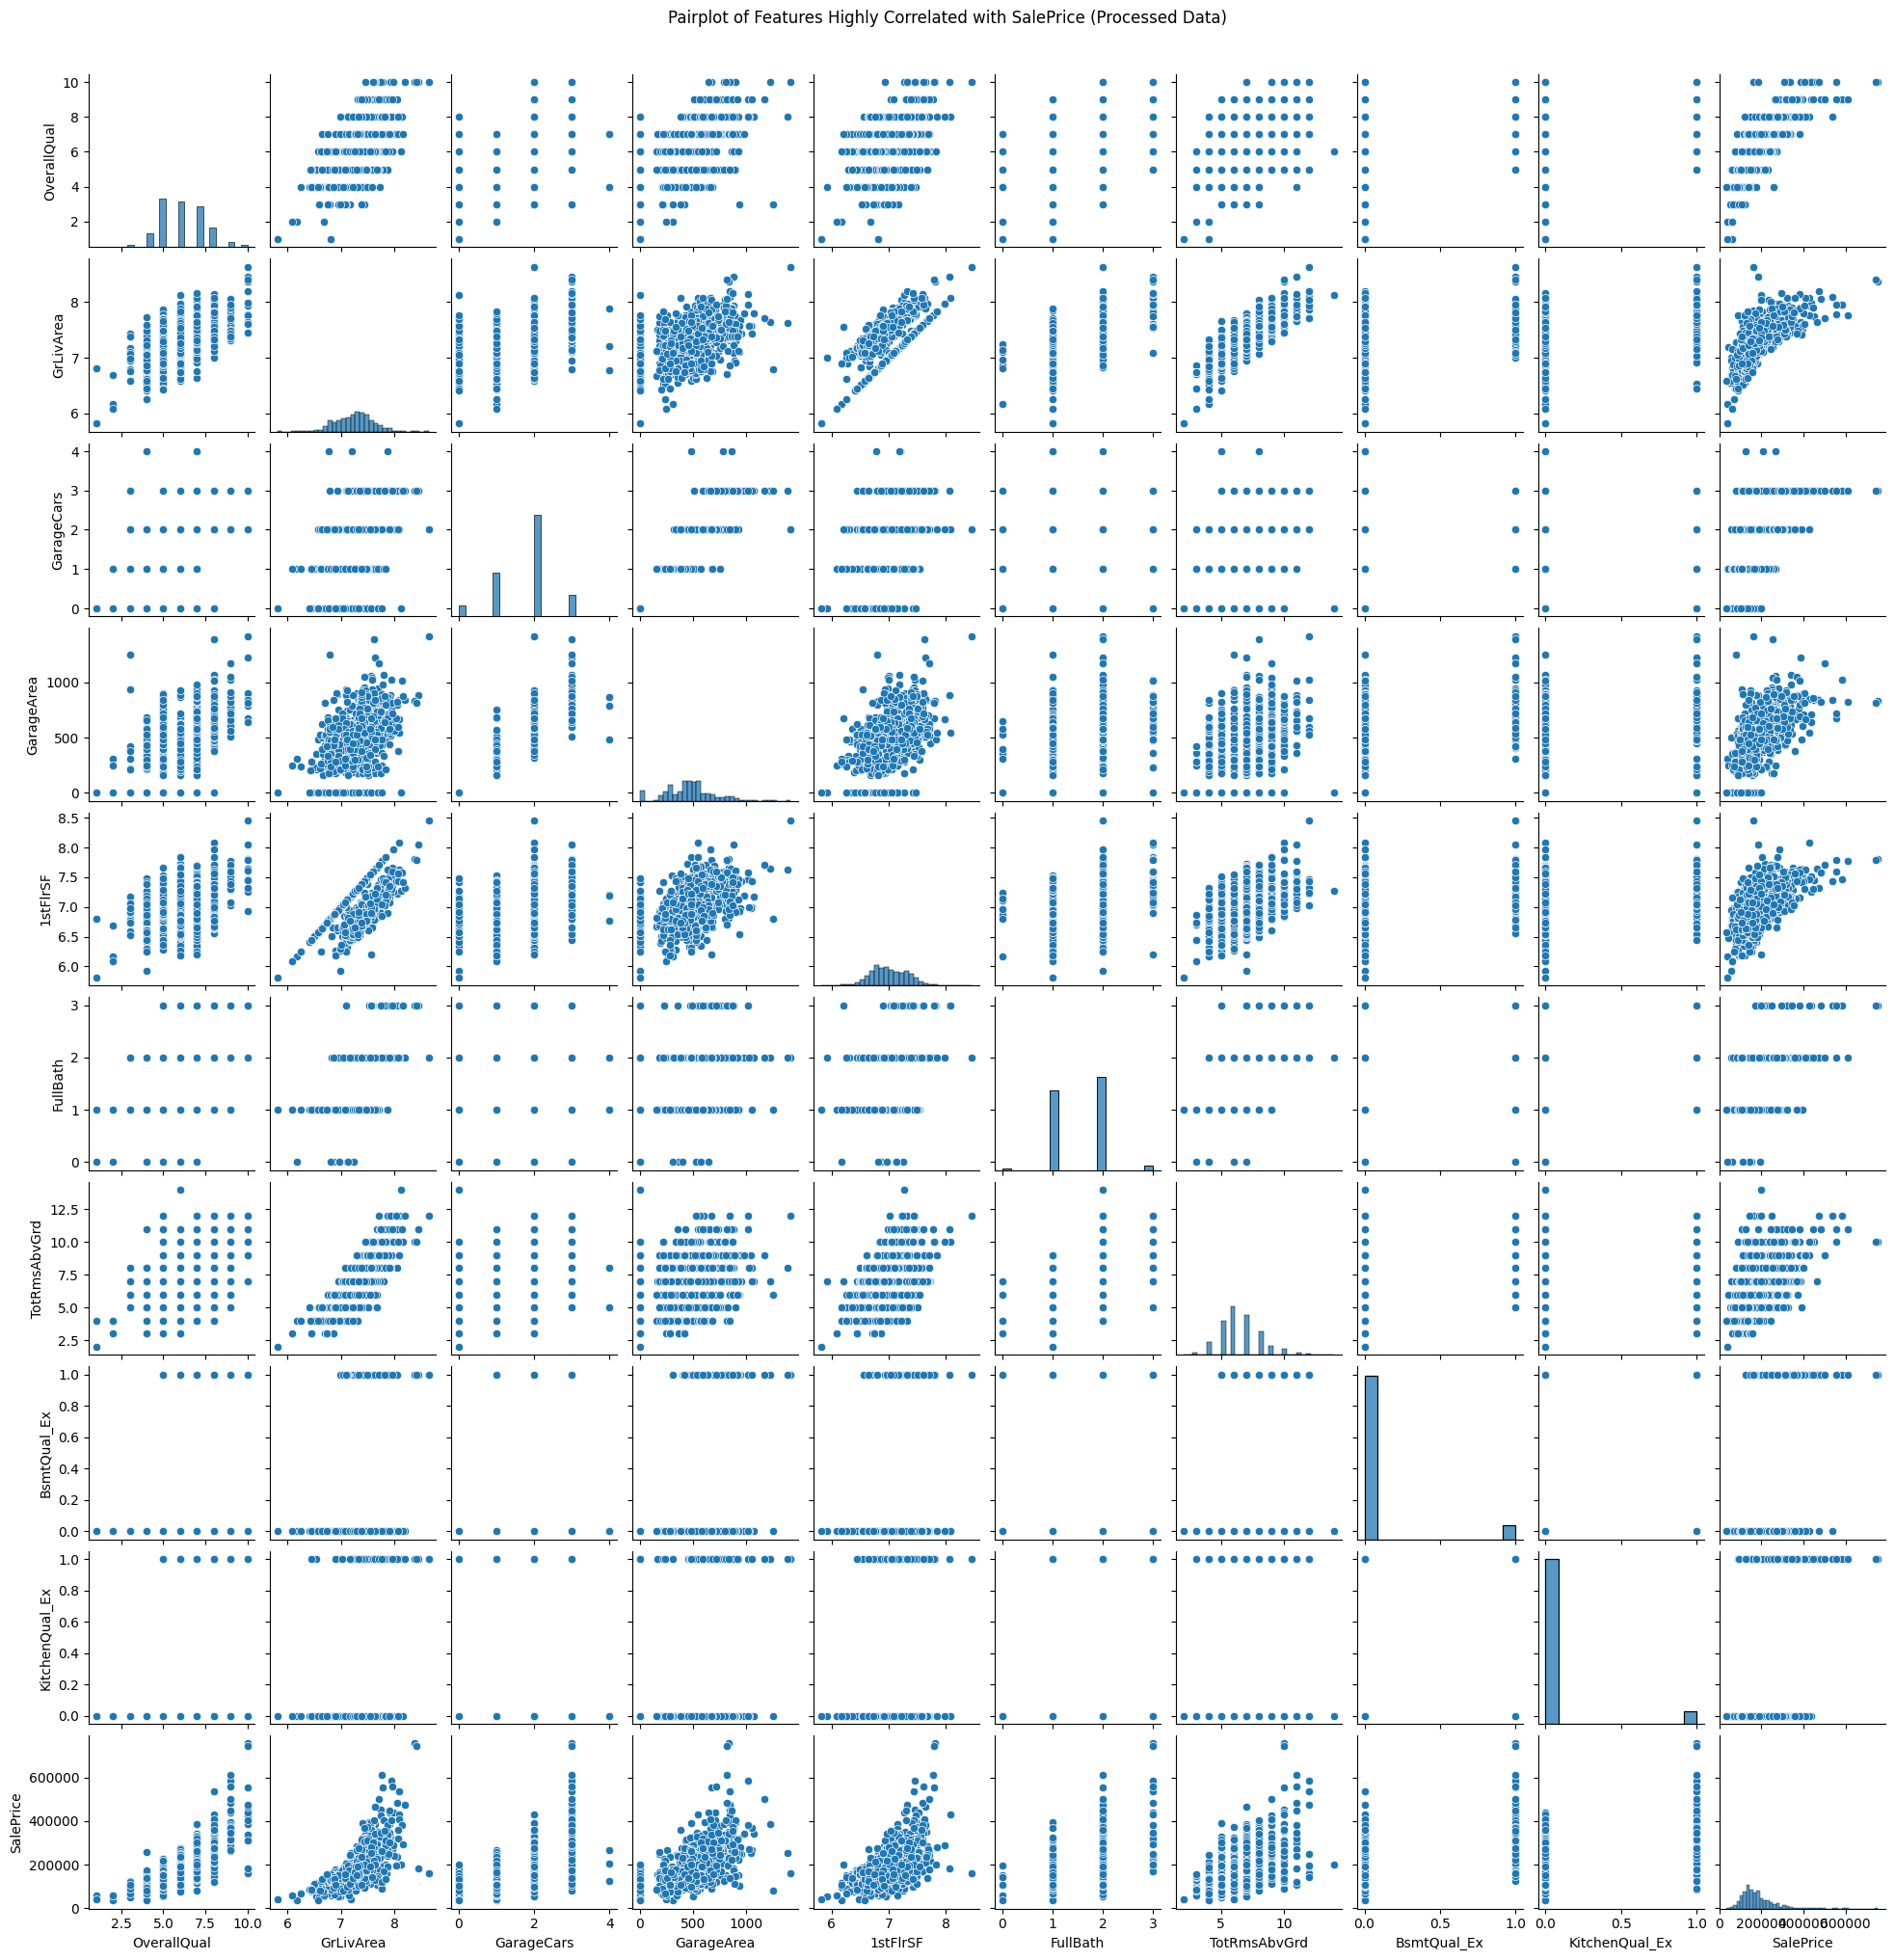

하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 32952.5171, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 35426.768, 최적 alpha:{'alpha': 10}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 28588.6483, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 164
[LightGBM] [Info] Start training from score 180483.222698
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

In [ ]:
# # 주택 가격 예측 프로젝트
# 캘리포니아의 주택 가격 데이터를 사용하여 다양한 회귀 모델을 구축하고, 스태킹 앙상블 기법을 적용하여 예측 성능을 개선
# ## 1. 데이터 이해 및 탐색
#
# 데이터셋은 주택의 다양한 features와 해당 주택의 판매 가격(SalePrice)으로 구성. 예측 대상은 'SalePrice'

!pip install catboost

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

# 데이터 로드
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()

print("데이터셋 정보:")
house_df.info()

print("\n데이터셋 상위 5행:")
display(house_df.head())

print("\n'SalePrice' 분포 시각화:")
sns.distplot(house_df['SalePrice'])
plt.title('Distribution of SalePrice')
plt.show()

# 결측치 확인
print("\n컬럼별 결측치 개수:")
print(house_df.isnull().sum().sort_values(ascending=False).head(20))


# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    # 원본 데이터에서 제거할 컬럼 목록 정의
    drop_cols = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
    # 데이터프레임에 해당 컬럼이 존재하는 경우에만 삭제
    existing_cols_to_drop = [col for col in drop_cols if col in df.columns]
    if existing_cols_to_drop:
        df.drop(existing_cols_to_drop, axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    # 숫자형 컬럼만 선택
    features_index = df.select_dtypes(include=np.number).columns
    # 대상 컬럼에서 'SalePrice' 제외 (타겟 변수는 전처리 함수에서 변환하지 않음)
    features_for_skew = [col for col in features_index if col != 'SalePrice']
    skew_features = df[features_for_skew].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # 로그 변환 적용
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    pred_exp = np.nan_to_num(pred_exp, posinf=1e10, neginf=0)
    y_test_exp = np.expm1(y_test) # 실제값 복원
    y_test_exp = np.nan_to_num(y_test_exp, posinf=1e10, neginf=0)


    mse = mean_squared_error(y_test_exp , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=156) # random_state 추가
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

# ## 2. 데이터 전처리 과정
#
# 모델 학습 전에 데이터를 정제하고 모델이 학습하기 쉬운 형태로 변환
#
# 1.  **불필요한 컬럼 제거:** 'Id'와 결측치가 너무 많은 일부 컬럼 ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu')을 제거한다.
# 2.  **결측치 처리:** 숫자형 컬럼의 결측치는 해당 컬럼의 평균값으로 대체한다.
# 3.  **이상치 처리:** 'GrLivArea'와 'SalePrice'의 관계를 시각적으로 확인한 결과, 일부 극단적인 이상치들이 발견되어서 제거한다.
# 4.  **피처 엔지니어링 - Skewness 변환:** 데이터의 분포가 한쪽으로 치우쳐(skewed) 있는 피처들은 모델의 예측 성능을 저하시킬 수 있다. Skewness가 높은 숫자형 피처들에 `np.log1p` (log(1+x)) 변환을 적용하여 분포를 정규화한다.
# 5.  **카테고리형 피처 인코딩:** 문자열 형태의 카테고리형 피처는 모델이 직접 처리할 수 없으므로, 원-핫 인코딩(`pd.get_dummies`)을 사용하여 숫자형 형태로 변환한다.

# %%
# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행한다.
# 이 함수를 호출한 후에 데이터는 수치형으로 변환된다.
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
# 로그 변환된 GrLivArea와 SalePrice를 기준으로 이상치 인덱스를 찾는다.
# house_df_ohe는 이미 SalePrice와 GrLivArea가 로그 변환된 상태다.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

print("\n전처리 후 데이터셋 shape:", house_df_ohe.shape)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

print("\n학습 데이터 shape:", X_train.shape)
print("검증 데이터 shape:", X_test.shape)
print("학습 타겟 shape:", y_train.shape)
print("검증 타겟 shape:", y_test.shape)

# 이제 데이터가 모두 수치형으로 변환되었으므로 상관관계 heatmap을 그릴 수 있다.
print("\n전처리 후 숫자형 피처의 상관관계 시각화 (heatmap):")
plt.figure(figsize=(12, 10))
# Use the processed DataFrame for correlation calculation
sns.heatmap(house_df_ohe.corr(), cmap='RdBu_r', annot=False)
plt.title('Correlation Matrix of Processed Features')
plt.show()

# 'SalePrice'와 상관관계가 높은 피처 시각화 (산점도)
if 'SalePrice' in house_df_ohe.columns:
    high_corr_features = house_df_ohe.corr()['SalePrice'].sort_values(ascending=False).index[1:10].tolist()
    features_to_plot = [col for col in high_corr_features if col in house_df_ohe.columns]
    if 'SalePrice' in house_df_ohe.columns:
         features_to_plot.append('SalePrice')

    if len(features_to_plot) > 1:
        sns.pairplot(house_df_ohe[features_to_plot], size=2)
        plt.suptitle('Pairplot of Features Highly Correlated with SalePrice (Processed Data)', y=1.02)
        plt.show()
    else:
        print("No high correlation features found to plot after preprocessing.")
else:
    print("'SalePrice' column not found in the processed data for correlation plotting.")


# ## 3. 모델 선택 및 비교
#
# 회귀 모델들을 사용 및 성능을 비교한다.
#
# 1.  **Ridge 회귀:** L2 규제를 사용하는 선형 회귀 모델이다. 다중 공선성 문제를 완화하고 모델의 복잡성을 줄이는 데 효과적이다.
# 2.  **Lasso 회귀:** L1 규제를 사용하는 선형 회귀 모델이다. 피처 선택 효과가 있어 중요하지 않은 피처의 계수를 0으로 만들어 모델을 더 간결하게 만든다.
# 3.  **XGBoost (Extreme Gradient Boosting):** 강력한 부스팅 기반 앙상블 모델이다. 뛰어난 예측 성능으로 다양한 데이터 과학 경연 대회에서 우수한 성적을 보여준다.
# 4.  **LightGBM (Light Gradient Boosting Machine):** XGBoost와 유사한 부스팅 모델이지만, 학습 속도가 빠르고 메모리 사용량이 적다는 장점이 있다. 대용량 데이터에 특히 효과적이다.
# 5.  **스태킹 앙상블:** 여러 개별 모델의 예측 결과를 다시 학습 데이터로 사용하여 최종 메타 모델을 학습하는 기법이다. 각 모델의 장점을 결합하여 개별 모델보다 더 나은 예측 성능을 기대할 수 있다. 여기서는 개별 모델들의 예측 결과를 기반으로 Lasso 회귀 모델을 메타 모델로 사용한다.
#
# 각 모델은 고유한 특성을 가지고 있으며, 데이터의 특성에 따라 성능 차이가 있다. 여러 모델을 비교해 데이터에 가장 적합한 모델을 찾고, 스태킹을 통해 모델들의 시너지를 활용한다.

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
rf_params = {'n_estimators': [100, 200, 500]}
gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}
cat_params = {} # CatBoostRegressor doesn't typically require extensive grid search for basic usage

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾는다.
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보한다.
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), cat_params, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의한다.
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용한다.
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
rf_reg = RandomForestRegressor(**best_rf.get_params())
gb_reg = GradientBoostingRegressor(**best_gb.get_params())
cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습한다.
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)
gb_reg.fit(X_train, y_train)
cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# ## 4. 성능평가
#
# 모델의 성능은 검증 데이터셋에 대한 RMSE (Root Mean Squared Error) 지표를 사용하여 평가한다. RMSE는 예측값과 실제값의 차이를 제곱하여 평균한 값에 루트를 씌운 것으로, 오류의 크기를 나타낸다. 값이 작을수록 모델의 예측 성능이 우수함을 의미한다. 특히 타겟 변수가 로그 변환되었으므로, 최종 RMSE는 `np.expm1`을 적용하여 원래 스케일로 복원된 값에 대해 계산한다.
#
# 하이퍼파라미터 튜닝은 `GridSearchCV`를 사용하여 수행했다. 각 모델별로 주요 하이퍼파라미터 그리드를 정의하고, 5-Fold Cross Validation을 통해 최적의 파라미터 조합을 찾았다. Grid Search 과정에서 각 파라미터 조합에 대한 교차 검증 평균 RMSE 값을 기록하고, 가장 낮은 RMSE를 보인 파라미터를 최종 모델에 적용했다.
#
# 스태킹 앙상블의 경우, KFold 교차 검증을 통해 개별 기반 모델들의 예측 결과를 생성하고, 이 결과를 학습 데이터로 사용하여 최종 메타 모델(Lasso)을 학습시켰다. 메타 모델은 개별 모델들의 예측 결과를 바탕으로 최종 예측을 수행하며, 이 예측값 또한 RMSE로 평가된다.

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg, rf_reg, gb_reg, cat_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환한다.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터를 생성한다.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합친다)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train, rf_train, gb_train, cat_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test, rf_test, gb_test, cat_test), axis=1) # 다른 모델의 테스트 데이터 추가

print("\n스태킹 학습 데이터 shape:", Stack_final_X_train.shape)
print("스태킹 테스트 데이터 shape:", Stack_final_X_test.shape)


# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습한다.
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습한다.
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터를 예측한다.
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가한다.
# 스태킹 테스트 데이터 예측 결과에 대해 y_test (로그 변환된 실제값)와의 RMSE를 계산한다.
# get_rmse 함수는 내부적으로 np.expm1을 적용하여 RMSE를 계산한다.
print('\n스태킹 회귀 모델 성능 평가:')
get_rmse(meta_model_lasso, Stack_final_X_test, y_test)


# 제출용 Test 데이터 전처리 및 예측한다.
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제한다.
drop_cols_test = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
existing_cols_to_drop_test = [col for col in drop_cols_test if col in test_df.columns]
if existing_cols_to_drop_test:
    test_df.drop(existing_cols_to_drop_test, axis=1 , inplace=True)


# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체한다.
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index는 학습 데이터에서 계산된 skewness가 높은 피처 인덱스이다.
# Test 데이터에는 'SalePrice' 컬럼이 없으므로 skew_features_top_index 전체를 사용한다.
# 하지만 preprocess_data 함수에서 이미 'SalePrice'를 제외하고 skewness를 계산했으므로 이 부분은 문제 없다.
# Test 데이터에만 존재하는 컬럼이 skew_features_top_index에 포함될 일은 없지만, 안전을 위해 확인한다.
skew_cols_for_test = [col for col in skew_features_top_index if col in test_df.columns]
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용한다.
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치시킨다.
# 학습 데이터에 없던 컬럼은 0으로 채우고, 테스트 데이터에 없던 컬럼은 삭제한다.
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측한다.
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환한다.
X_features_np = X_features.values
y_target_np = y_target.values # 전체 학습 데이터의 타겟값
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행한다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용한다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
rf_test_pred_for_submission = get_stacking_base_datasets(rf_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
gb_test_pred_for_submission = get_stacking_base_datasets(gb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
cat_test_pred_for_submission = get_stacking_base_datasets(cat_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]


# 메타 모델이 사용할 테스트 데이터를 결합한다.
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission,
    rf_test_pred_for_submission,
    gb_test_pred_for_submission,
    cat_test_pred_for_submission
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터를 예측한다.
# 메타 모델은 전체 학습 데이터로 학습된 상태다.
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리한다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일을 생성한다.
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장한다.
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

In [13]:
# 20469

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # Note: 'SalePrice' will be in skew_features_top_index if it's in df,
    # but we handle this separately during test data preprocessing.
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
# rf_params = {'n_estimators': [100, 200, 500]}
# gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index에서 'SalePrice'가 있다면 제외하고 적용
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline # 주피터 노트북 환경에서만 필요

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor

# 데이터 전처리 함수
def preprocess_data(df):
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 파라미터:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False) # 원본 유지
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]} # XGBoost는 n_estimators만 튜닝 예시로 남김

print("하이퍼파라미터 튜닝 시작...")
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
xgb_reg = XGBRegressor(**best_xgb.get_params())

print("\n개별 모델 학습 시작...")
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg] # 사용 모델 리스트 변경
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (3개 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test), axis=1)

# 최종 메타 모델 (Ridge) 정의 및 학습
meta_model_ridge = Ridge(alpha=0.1) # Ridge 메타 모델, alpha는 임의값 (튜닝 필요)
print("\n메타 모델(Ridge) 학습 시작...")
meta_model_ridge.fit(Stack_final_X_train, y_train)
print("메타 모델(Ridge) 학습 완료.")
final_pred_stacking = meta_model_ridge.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])
test_ohe1 = pd.get_dummies(test_df)
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)
print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]

Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission
), axis=1)

final_test_pred = meta_model_ridge.predict(Stack_final_X_test_for_submission) # 메타 모델 Ridge로 예측
print("스태킹 모델 테스트 데이터 예측 완료.")

final_test_pred_exp = np.expm1(final_test_pred)
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)

sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission.csv", index=False)
print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)


하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 파라미터:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 파라미터:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 파라미터:{'n_estimators': 1000}
하이퍼파라미터 튜닝 완료.

개별 모델 학습 시작...
개별 모델 학습 완료.

개별 모델 RMSE:
Ridge 로그 변환된 RMSE: 20989.311
Lasso 로그 변환된 RMSE: 20410.53
XGBRegressor 로그 변환된 RMSE: 21785.701

스태킹 기반 데이터 생성 시작...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
스태킹 기반 데이터 생성 완료.

메타 모델(Ridge) 학습 시작...
메타 모델(Ridge) 학습 완료.

스태킹 회귀 모델의 최종 RMSE 값은: 0.11026251422087155

테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape: (292, 266)

스태킹 모델 테스트 데이터 예측 시작...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0 

In [ ]:
# 20469

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # Note: 'SalePrice' will be in skew_features_top_index if it's in df,
    # but we handle this separately during test data preprocessing.
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
# rf_params = {'n_estimators': [100, 200, 500]}
# gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index에서 'SalePrice'가 있다면 제외하고 적용
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 결측치 및 불필요 컬럼 제거
drop_cols = ['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

# 숫자형 결측치 평균 대체
for df in [train, test]:
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 왜도 높은 컬럼 로그 변환 (SalePrice 제외) ★ 수정된 부분
numeric_feats = train.drop('SalePrice', axis=1).select_dtypes(include='number').columns
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
high_skew = skewed_feats[skewed_feats > 1].index

for df in [train, test]:
    df[high_skew] = np.log1p(df[high_skew])

# 원-핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)
test = test.reindex(columns=train.columns.drop('SalePrice'), fill_value=0)

# 이상치 제거 (GrLivArea > 4000 and SalePrice < 500000)
outlier_idx = train[(train['GrLivArea'] > np.log1p(4000)) & (train['SalePrice'] < np.log1p(500000))].index
train = train.drop(outlier_idx)

# 타겟/피처 분리
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)
X_sub = test

# RobustScaler 적용
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_sub_scaled = scaler.transform(X_sub)

# 학습/검증 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 정의
cat = CatBoostRegressor(verbose=0, random_state=42)
rf = RandomForestRegressor(n_estimators=500, random_state=42)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)

base_models = [cat, rf]
meta_models = [elastic, lgbm, cat]

# 스태킹용 데이터 생성 함수
def get_stacking_data(models, X, y, X_test, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_meta = np.zeros((X.shape[0], len(models)))
    test_meta = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        test_fold_preds = []
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr = y.iloc[train_idx]
            model.fit(X_tr, y_tr)
            train_meta[val_idx, i] = model.predict(X_val)
            test_fold_preds.append(model.predict(X_test))
        test_meta[:, i] = np.mean(test_fold_preds, axis=0)
    return train_meta, test_meta

# 스태킹 데이터 생성
stack_train, stack_test = get_stacking_data(base_models, X_train, y_train, X_valid, n_folds=5)
stack_sub_train, stack_sub_test = get_stacking_data(base_models, X_scaled, y, X_sub_scaled, n_folds=5)

# 메타 모델별 성능 비교
print('메타 모델별 검증 RMSE:')
for meta in meta_models:
    meta.fit(stack_train, y_train)
    pred = meta.predict(stack_test)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(pred)))
    print(f'{meta.__class__.__name__}: {rmse:.4f}')

# 최적 메타 모델 선택 (여기서는 LGBMRegressor 예시)
final_meta = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
final_meta.fit(stack_sub_train, y)
final_pred = final_meta.predict(stack_sub_test)
final_pred_exp = np.expm1(final_pred)
final_pred_exp = np.nan_to_num(final_pred_exp, posinf=1e10, neginf=0)

# 제출 파일 생성
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = final_pred_exp
submission.to_csv('submission.csv', index=False)
print('submission.csv 파일이 생성되었습니다.')

메타 모델별 검증 RMSE:


ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:

best_rmse = float('inf')
best_meta = None
best_meta_name = ''

print('\n메타 모델별 검증 RMSE:')
for model, name in zip(meta_models, meta_model_names):
    model.fit(stack_train, y_train)
    pred = model.predict(stack_test)

    # 무한대 값 처리 (추가된 부분)
    pred_exp = np.expm1(pred)
    pred_exp = np.nan_to_num(pred_exp, posinf=1e10, neginf=0)  # 무한대 → 1e10
    y_valid_exp = np.expm1(y_valid)  # 실제값 복원

    rmse = np.sqrt(mean_squared_error(y_valid_exp, pred_exp))
    print(f'{name}: {rmse:.4f}')

    if rmse < best_rmse:
        best_rmse = rmse
        best_meta = model
        best_meta_name = name

print(f'\n[최적 메타 모델] {best_meta_name} (RMSE: {best_rmse:.4f})')

# ------------------- 최종 예측 및 제출 -------------------
best_meta.fit(stack_sub_train, y)
final_pred = best_meta.predict(stack_sub_test)

# 무한대 값 처리 (추가된 부분)
final_pred_exp = np.expm1(final_pred)
final_pred_exp = np.nan_to_num(final_pred_exp, posinf=1e10, neginf=0)

submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = final_pred_exp
submission.to_csv('submission.csv', index=False)
print('\nsubmission.csv 파일이 생성되었습니다.')

In [6]:
# Install catboost
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy.stats import skew, randint, uniform
import warnings

warnings.filterwarnings('ignore')

# 1. 데이터 로드 및 전처리
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

drop_cols = ['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

for df in [train, test]:
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 왜도 높은 컬럼 로그 변환 (SalePrice 제외)
numeric_feats = train.drop('SalePrice', axis=1).select_dtypes(include='number').columns
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
high_skew = skewed_feats[skewed_feats > 1].index
for df in [train, test]:
    df[high_skew] = np.log1p(df[high_skew])

# 원-핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)
test = test.reindex(columns=train.columns.drop('SalePrice'), fill_value=0)

# 이상치 제거
outlier_idx = train[(train['GrLivArea'] > np.log1p(4000)) & (train['SalePrice'] < np.log1p(500000))].index
train = train.drop(outlier_idx)

# 타겟/피처 분리
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)
X_sub = test

# RobustScaler 적용
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_sub_scaled = scaler.transform(X_sub)

# 학습/검증 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. 하이퍼파라미터 튜닝 (RandomizedSearchCV)
def random_search(model, params, X, y, model_name, n_iter=10):
    print(f"\nRandomizedSearchCV for {model_name}...")
    search = RandomizedSearchCV(
        model, params, n_iter=n_iter, scoring='neg_mean_squared_error',
        cv=3, n_jobs=-1, random_state=42
    )
    search.fit(X, y)
    print(f"Best params for {model_name}: {search.best_params_}")
    print(f"Best RMSE for {model_name}: {np.sqrt(-search.best_score_):.4f}")
    return search.best_estimator_

cat_params = {
    'iterations': randint(300, 700),
    'depth': randint(4, 8),
    'learning_rate': uniform(0.03, 0.12),
    'l2_leaf_reg': randint(1, 5)
}
rf_params = {
    'n_estimators': randint(200, 400),
    'max_depth': [None, 8, 12],
    'max_features': ['sqrt', 0.8]
}
lgbm_params = {
    'n_estimators': randint(500, 900),
    'learning_rate': uniform(0.03, 0.08),
    'num_leaves': randint(16, 48),
    'subsample': uniform(0.7, 0.3)
}
elastic_params = {
    'alpha': uniform(0.001, 0.1),
    'l1_ratio': uniform(0, 1)
}

cat = random_search(CatBoostRegressor(verbose=0, early_stopping_rounds=50, random_state=42),
                   cat_params, X_train, y_train, 'CatBoost', n_iter=10)
rf = random_search(RandomForestRegressor(n_jobs=-1, random_state=42),
                  rf_params, X_train, y_train, 'RandomForest', n_iter=10)
lgbm = random_search(LGBMRegressor(n_jobs=-1, random_state=42),
                    lgbm_params, X_train, y_train, 'LGBM', n_iter=12)
elastic = random_search(ElasticNet(random_state=42),
                       elastic_params, X_train, y_train, 'ElasticNet', n_iter=12)

base_models = [cat, rf]
meta_models = [elastic, lgbm]
meta_model_names = ['ElasticNet', 'LGBM']

# 3. 스태킹 데이터 생성
def get_stacking_data(models, X, y, X_test, n_folds=3):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_meta = np.zeros((X.shape[0], len(models)))
    test_meta = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        test_fold_preds = []
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr = y.iloc[train_idx]
            model.fit(X_tr, y_tr)
            train_meta[val_idx, i] = model.predict(X_val)
            test_fold_preds.append(model.predict(X_test))
        test_meta[:, i] = np.mean(test_fold_preds, axis=0)
    return train_meta, test_meta

stack_train, stack_test = get_stacking_data(base_models, X_train, y_train, X_valid, n_folds=3)
stack_sub_train, stack_sub_test = get_stacking_data(base_models, X_scaled, y, X_sub_scaled, n_folds=3)

# 4. 메타 모델별 성능 비교 및 최적 선택
best_rmse = float('inf')
best_meta = None
best_meta_name = ''

print('\n메타 모델별 검증 RMSE:')
for model, name in zip(meta_models, meta_model_names):
    model.fit(stack_train, y_train)
    pred = model.predict(stack_test)
    pred_exp = np.expm1(pred)
    pred_exp = np.nan_to_num(pred_exp, posinf=1e10, neginf=0)
    y_valid_exp = np.expm1(y_valid)
    y_valid_exp = np.nan_to_num(y_valid_exp, posinf=1e10, neginf=0)
    rmse = np.sqrt(mean_squared_error(y_valid_exp, pred_exp))
    print(f'{name}: {rmse:.4f}')
    if rmse < best_rmse:
        best_rmse = rmse
        best_meta = model
        best_meta_name = name

print(f'\n[최적 메타 모델] {best_meta_name} (RMSE: {best_rmse:.4f})')

# 5. 최종 예측 및 제출
best_meta.fit(stack_sub_train, y)
final_pred = best_meta.predict(stack_sub_test)
final_pred_exp = np.expm1(final_pred)
final_pred_exp = np.nan_to_num(final_pred_exp, posinf=1e10, neginf=0)

submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = final_pred_exp
submission.to_csv('submission.csv', index=False)
print('\nsubmission.csv 파일이 생성되었습니다.')


RandomizedSearchCV for CatBoost...
Best params for CatBoost: {'depth': 4, 'iterations': 557, 'l2_leaf_reg': 4, 'learning_rate': np.float64(0.1298931168960506)}
Best RMSE for CatBoost: 30150.9926

RandomizedSearchCV for RandomForest...
Best params for RandomForest: {'max_depth': 12, 'max_features': 0.8, 'n_estimators': 252}
Best RMSE for RandomForest: 33308.1124

RandomizedSearchCV for LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 162
[LightGBM] [Info] Start training from score 178344.738758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.stats import skew, randint, uniform
import warnings

warnings.filterwarnings('ignore')

# 1. 데이터 로드 및 전처리
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

drop_cols = ['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

for df in [train, test]:
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 왜도 높은 컬럼 로그 변환 (SalePrice 제외)
numeric_feats = train.drop('SalePrice', axis=1).select_dtypes(include='number').columns
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
high_skew = skewed_feats[skewed_feats > 1].index
for df in [train, test]:
    df[high_skew] = np.log1p(df[high_skew])

# 원-핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)
test = test.reindex(columns=train.columns.drop('SalePrice'), fill_value=0)

# 이상치 제거
outlier_idx = train[(train['GrLivArea'] > np.log1p(4000)) & (train['SalePrice'] < np.log1p(500000))].index
train = train.drop(outlier_idx)

# 타겟/피처 분리
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)
X_sub = test

# 학습/검증 분할 먼저!
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# RobustScaler (학습 데이터로만 fit)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_sub_scaled = scaler.transform(X_sub)

# 2. 하이퍼파라미터 튜닝 (RandomizedSearchCV)
def random_search(model, params, X, y, model_name, n_iter=10):
    print(f"\nRandomizedSearchCV for {model_name}...")
    search = RandomizedSearchCV(
        model, params, n_iter=n_iter, scoring='neg_mean_squared_error',
        cv=3, n_jobs=-1, random_state=42
    )
    search.fit(X, y)
    print(f"Best params for {model_name}: {search.best_params_}")
    print(f"Best RMSE for {model_name}: {np.sqrt(-search.best_score_):.4f}")
    return search.best_estimator_

cat_params = {
    'iterations': randint(300, 700),
    'depth': randint(4, 8),
    'learning_rate': uniform(0.03, 0.12),
    'l2_leaf_reg': randint(1, 5)
}
rf_params = {
    'n_estimators': randint(200, 400),
    'max_depth': [None, 8, 12],
    'max_features': ['sqrt', 0.8]
}
elastic_params = {
    'alpha': uniform(0.001, 0.1),
    'l1_ratio': uniform(0, 1)
}
ridge_params = {
    'alpha': uniform(0.1, 10)
}

cat = random_search(CatBoostRegressor(verbose=0, early_stopping_rounds=50, random_state=42),
                   cat_params, X_train, y_train, 'CatBoost', n_iter=10)
rf = random_search(RandomForestRegressor(n_jobs=-1, random_state=42),
                  rf_params, X_train, y_train, 'RandomForest', n_iter=10)
elastic = random_search(ElasticNet(random_state=42),
                       elastic_params, X_train, y_train, 'ElasticNet', n_iter=12)
ridge = random_search(Ridge(random_state=42),
                     ridge_params, X_train, y_train, 'Ridge', n_iter=10)

# base 모델 2개
base_models = [cat, rf]

# 3. 스태킹 데이터 생성
def get_stacking_data(models, X, y, X_test, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_meta = np.zeros((X.shape[0], len(models)))
    test_meta = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        test_fold_preds = []
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr = y.iloc[train_idx]
            model.fit(X_tr, y_tr)
            train_meta[val_idx, i] = model.predict(X_val)
            test_fold_preds.append(model.predict(X_test))
        test_meta[:, i] = np.mean(test_fold_preds, axis=0)
    return train_meta, test_meta

stack_train, stack_test = get_stacking_data(base_models, X_train, y_train, X_valid, n_folds=5)
stack_sub_train, stack_sub_test = get_stacking_data(base_models, scaler.transform(X), y, X_sub_scaled, n_folds=5)

# 4. 메타 모델 비교 및 선택
meta_models = [ElasticNet(alpha=elastic.alpha, l1_ratio=elastic.l1_ratio, random_state=42),
               Ridge(alpha=ridge.alpha, random_state=42)]
meta_model_names = ['ElasticNet', 'Ridge']

best_rmse = float('inf')
best_meta = None
best_meta_name = ''

print('\n메타 모델별 검증 RMSE:')

for model, name in zip(meta_models, meta_model_names):
    model.fit(stack_train, y_train)
    pred = model.predict(stack_test)
    pred_exp = np.expm1(pred)
    pred_exp = np.nan_to_num(pred_exp, posinf=1e10, neginf=0)
    y_valid_exp = np.expm1(y_valid)
    y_valid_exp = np.nan_to_num(y_valid_exp, posinf=1e10, neginf=0)
    rmse = np.sqrt(mean_squared_error(y_valid_exp, pred_exp))
    print(f'{name}: {rmse:.4f}')
    if rmse < best_rmse:
        best_rmse = rmse
        best_meta = model
        best_meta_name = name


print(f'\n[최적 메타 모델] {best_meta_name} (RMSE: {best_rmse:.4f})')

# 5. 최종 예측 및 제출
best_meta.fit(stack_sub_train, y)
final_pred = best_meta.predict(stack_sub_test)
final_pred_exp = np.expm1(final_pred)
final_pred_exp = np.nan_to_num(final_pred_exp, posinf=1e8, neginf=0)

submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = final_pred_exp
submission.to_csv('submission.csv', index=False)
print('\nsubmission.csv 파일이 생성되었습니다.')

# 단순 평균 앙상블도 병행해서 결과 비교 추천
base_preds = [model.predict(X_sub_scaled) for model in base_models]
base_preds_exp = [np.expm1(pred) for pred in base_preds]
mean_pred = np.mean(base_preds_exp, axis=0)
submission['SalePrice'] = mean_pred
submission.to_csv('submission_mean_ensemble.csv', index=False)
print('submission_mean_ensemble.csv 파일도 생성되었습니다.')



RandomizedSearchCV for CatBoost...
Best params for CatBoost: {'depth': 4, 'iterations': 557, 'l2_leaf_reg': 4, 'learning_rate': np.float64(0.1298931168960506)}
Best RMSE for CatBoost: 30145.3974

RandomizedSearchCV for RandomForest...
Best params for RandomForest: {'max_depth': 12, 'max_features': 0.8, 'n_estimators': 252}
Best RMSE for RandomForest: 33309.2538

RandomizedSearchCV for ElasticNet...
Best params for ElasticNet: {'alpha': np.float64(0.031424224295953776), 'l1_ratio': np.float64(0.5247564316322378)}
Best RMSE for ElasticNet: 33926.8543

RandomizedSearchCV for Ridge...
Best params for Ridge: {'alpha': np.float64(9.60714306409916)}
Best RMSE for Ridge: 33927.5045

메타 모델별 검증 RMSE:
ElasticNet: 0.0000
Ridge: 0.0000

[최적 메타 모델] ElasticNet (RMSE: 0.0000)

submission.csv 파일이 생성되었습니다.
submission_mean_ensemble.csv 파일도 생성되었습니다.


In [9]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # Note: 'SalePrice' will be in skew_features_top_index if it's in df,
    # but we handle this separately during test data preprocessing.
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
# rf_params = {'n_estimators': [100, 200, 500]}
# gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index에서 'SalePrice'가 있다면 제외하고 적용
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [10]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor # CatBoost 사용을 위해 임포트

# 데이터 로드 및 전처리 함수 (SalePrice는 여기서 변환하지 않음)
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    # 원본 데이터에서 제거할 컬럼 목록 정의
    drop_cols = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
    # 데이터프레임에 해당 컬럼이 존재하는 경우에만 삭제
    existing_cols_to_drop = [col for col in drop_cols if col in df.columns]
    if existing_cols_to_drop:
        df.drop(existing_cols_to_drop, axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    # 'SalePrice' 컬럼이 있다면 Null 처리에서 제외 (이미 drop_cols에 없다는 가정 하에)
    num_cols = df.select_dtypes(include=np.number).columns
    # Null값 처리 시 SalePrice 컬럼 제외 (회귀 모델의 타겟)
    num_cols_for_fillna = [col for col in num_cols if col != 'SalePrice']
    df[num_cols_for_fillna] = df[num_cols_for_fillna].fillna(df[num_cols_for_fillna].mean())

    # Skewness가 높은 피처 로그 변환 (SalePrice는 여기서 변환하지 않음)
    # 숫자형 컬럼만 선택
    features_index = df.select_dtypes(include=np.number).columns
    # 대상 컬럼에서 'SalePrice' 제외
    features_for_skew = [col for col in features_index if col != 'SalePrice']
    # Null 값만 있는 컬럼에 skew 계산 시 오류 방지
    skew_features = df[features_for_skew].apply(lambda x : skew(x) if len(x.dropna()) > 1 else 0)
    skew_features_top = skew_features[skew_features > 1]
    # 로그 변환 적용
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수 (y_test는 원본 스케일이라고 가정)
def get_rmse(model, X_test, y_test_org):
    # 모델은 로그 변환된 타겟으로 학습되므로 예측값도 로그 스케일
    pred_log = model.predict(X_test)
    # 예측값을 원본 스케일로 복원
    pred_exp = np.expm1(pred_log)
    # 복원된 예측값에 NaN/inf가 있다면 처리
    # float64 타입이 표현할 수 있는 최대/최소 값으로 대체하여 극단적인 값으로 인한 오류 방지
    pred_exp = np.nan_to_num(pred_exp, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

    # y_test_org는 원본 스케일이므로 복원 필요 없음. NaN/inf 처리만 수행
    y_test_cleaned = np.nan_to_num(y_test_org, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

    # 실제 원본 스케일 값 (y_test_cleaned)과 복원된 예측값 (pred_exp)으로 MSE 계산
    mse = mean_squared_error(y_test_cleaned , pred_exp)
    rmse = np.sqrt(mse)
    # 출력 메시지 수정: 모델은 로그 변환 타겟으로 학습되었지만, RMSE는 원본 스케일에서 계산됨을 명시
    print('{0} 원본 스케일 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수 (타겟 변수 y_target_log 사용)
def get_best_model(model, params, X_features, y_target_log):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    # 학습 데이터는 로그 변환된 타겟을 사용
    grid_model.fit(X_features, y_target_log)
    # 최적 RMSE 계산 (neg_mean_squared_error는 로그 스케일에서의 MSE를 기반으로 함)
    # 여기서의 rmse는 '로그 스케일'에서의 CV 평균 RMSE입니다.
    rmse_log_scale = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE (로그 스케일): {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse_log_scale, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수 (타겟 변수 y_train_log_n 사용)
# 이 함수는 로그 스케일 타겟으로 학습/예측하고 로그 스케일 예측값을 반환합니다.
def get_stacking_base_datasets(model, X_train_n, y_train_log_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=156) # random_state 추가
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred_log = np.zeros((X_train_n.shape[0] ,1 )) # 로그 스케일 예측값을 저장
    test_pred_log = np.zeros((X_test_n.shape[0],n_folds))   # 로그 스케일 예측값을 저장
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr_log = y_train_log_n[train_index] # 로그 변환된 타겟 사용
        X_te = X_train_n[valid_index]

        # 기반 모델 학습 (로그 변환된 타겟으로 학습)
        model.fit(X_tr , y_tr_log)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장 (로그 스케일 예측값)
        train_fold_pred_log[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장 (로그 스케일 예측값)
        test_pred_log[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성 (로그 스케일 평균 예측값)
    test_pred_mean_log = np.mean(test_pred_log, axis=1).reshape(-1,1)

    #train_fold_pred_log는 최종 메타 모델이 사용하는 학습 데이터 (로그 스케일 예측값), test_pred_mean_log는 테스트 데이터 (로그 스케일 평균 예측값)
    return train_fold_pred_log , test_pred_mean_log


## 2. 데이터 전처리 과정

# 데이터 로드
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()

# 이상치 제거를 preprocess_data 호출 전에 수행하여 SalePrice 원본 값을 사용
# GrLivArea와 SalePrice 기준으로 이상치 판단 (원본 스케일 값으로 비교)
# 원본 데이터에서 GrLivArea > 4000 and SalePrice < 500000 인 경우를 이상치로 판단
cond1_org = house_df['GrLivArea'] > 4000
cond2_org = house_df['SalePrice'] < 500000
# AND 조건이 아닌 OR 조건으로 이상치를 판단하는 경우가 더 많습니다.
# 여기서는 원래 코드의 AND 조건을 따르지만, 실제 분석에서는 이상치 기준을 신중하게 선택해야 합니다.
outlier_index_org = house_df[cond1_org & cond2_org].index
house_df.drop(outlier_index_org , axis=0, inplace=True)

print("이상치 제거 후 데이터셋 shape:", house_df.shape)

# 이상치 제거된 데이터에 대해 전처리 수행 (SalePrice는 여기서 로그 변환되지 않음)
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

print("전처리 후 데이터셋 shape:", house_df_ohe.shape)


# 학습 데이터와 타겟 데이터 분리
# SalePrice는 house_df_ohe에 원본 스케일 값으로 남아있음
y_target_org = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

# 타겟 변수(SalePrice) 로그 변환
y_target_log = np.log1p(y_target_org) # 학습/검증에 사용할 로그 변환된 타겟

# 학습/검증 데이터 분할
# X는 특징, y는 로그 변환된 타겟 사용
X_train, X_test, y_train_log, y_test_log = train_test_split(X_features, y_target_log, test_size=0.2, random_state=156)

# 원본 스케일의 y_test는 get_rmse에서 사용하기 위해 y_test_log를 복원하여 별도로 저장
y_test_org = np.expm1(y_test_log)

print("\n학습 데이터 shape:", X_train.shape)
print("검증 데이터 shape:", X_test.shape)
print("학습 타겟 (로그 변환) shape:", y_train_log.shape)
print("검증 타겟 (로그 변환) shape:", y_test_log.shape)
print("검증 타겟 (원본 스케일) shape:", y_test_org.shape) # RMSE 계산에 사용될 변수

## 3. 모델 선택 및 비교

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000], 'learning_rate':[0.05], 'colsample_bytree':[0.5], 'subsample':[0.8]} # 예시 파라미터 추가
lgbm_params = {'n_estimators':[1000], 'learning_rate':[0.05], 'num_leaves':[4], 'subsample':[0.6], 'colsample_bytree':[0.4], 'reg_lambda':[10], 'n_jobs':[-1]} # 예시 파라미터 추가
rf_params = {'n_estimators': [100, 200]} # 예시 파라미터 그리드 축소
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]} # 예시 파라미터 그리드 축소
cat_params = {} # CatBoostRegressor는 기본 파라미터로 사용

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 로그 변환된 타겟 변수 y_target_log를 사용하여 최적 파라미터 찾음
# Note: GridSearchCV는 전체 X_features, y_target_log로 수행합니다.
# 분리된 X_train, y_train_log로 수행해도 되지만, 일반적으로는 전체 데이터로 최적 파라미터를 찾습니다.
# 여기서는 원래 코드를 따라 전체 데이터로 최적 파라미터를 찾습니다.
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target_log)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target_log)
# get_best_model 내에서 이미 random_state가 포함된 XGBRegressor/LGBMRegressor가 전달됩니다.
best_xgb = get_best_model(XGBRegressor(random_state=156), xgb_params, X_features, y_target_log)
best_lgbm = get_best_model(LGBMRegressor(random_state=156), lgbm_params, X_features, y_target_log)
best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target_log)
best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target_log)
best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), cat_params, X_features, y_target_log)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
# get_params()를 사용하여 최적 파라미터 적용
ridge_reg = Ridge(**best_ridge.get_params())
lasso_reg = Lasso(**best_lasso.get_params())
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
rf_reg = RandomForestRegressor(**best_rf.get_params())
gb_reg = GradientBoostingRegressor(**best_gb.get_params())
cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터 (X_train, y_train_log)로 개별 모델 학습
ridge_reg.fit(X_train, y_train_log)
lasso_reg.fit(X_train, y_train_log)
xgb_reg.fit(X_train, y_train_log)
lgbm_reg.fit(X_train, y_train_log)
rf_reg.fit(X_train, y_train_log)
gb_reg.fit(X_train, y_train_log)
cat_reg.fit(X_train, y_train_log)
print("개별 모델 학습 완료.")

## 4. 성능평가

# 개별 모델 RMSE 평가 (원본 스케일 y_test_org 사용)
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg, rf_reg, gb_reg, cat_reg] # 사용 모델 리스트
print("\n개별 모델 원본 스케일 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test_org) # y_test_org 전달

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_log_n = y_train_log.values # 로그 변환된 학습 타겟 사용

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터를 생성
# y_train_log_n을 사용하여 기반 모델 학습 및 로그 스케일 예측값 반환
ridge_train_log, ridge_test_log = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_log_n, X_test_n, 5)
lasso_train_log, lasso_test_log = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_log_n, X_test_n, 5)
xgb_train_log, xgb_test_log = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_log_n, X_test_n, 5)
lgbm_train_log, lgbm_test_log = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_log_n, X_test_n, 5)
rf_train_log, rf_test_log = get_stacking_base_datasets(rf_reg, X_train_n, y_train_log_n, X_test_n, 5)
gb_train_log, gb_test_log = get_stacking_base_datasets(gb_reg, X_train_n, y_train_log_n, X_test_n, 5)
cat_train_log, cat_test_log = get_stacking_base_datasets(cat_reg, X_train_n, y_train_log_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 로그 스케일 예측 결과를 열 방향으로 합친다)
# Stack_final_X_train은 로그 스케일 예측값으로 구성
Stack_final_X_train = np.concatenate((ridge_train_log, lasso_train_log, xgb_train_log, lgbm_train_log, rf_train_log, gb_train_log, cat_train_log), axis=1)
# Stack_final_X_test는 로그 스케일 평균 예측값으로 구성
Stack_final_X_test = np.concatenate((ridge_test_log, lasso_test_log, xgb_test_log, lgbm_test_log, rf_test_log, gb_test_log, cat_test_log), axis=1)

print("\n스태킹 학습 데이터 (로그 스케일 예측값) shape:", Stack_final_X_train.shape)
print("스태킹 테스트 데이터 (로그 스케일 평균 예측값) shape:", Stack_final_X_test.shape)


# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습한다.
# 메타 모델은 로그 스케일 예측값을 입력으로 받아, 로그 변환된 실제 타겟(y_train_log)을 예측한다.
meta_model_lasso = Lasso(alpha=0.0005) # 스태킹 메타 모델의 alpha 값은 튜닝 필요
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터 (로그 스케일 예측값)를 사용하여 로그 변환된 타겟(y_train_log)을 학습한다.
meta_model_lasso.fit(Stack_final_X_train, y_train_log)
print("메타 모델 학습 완료.")

# 메타 모델을 사용하여 스태킹 테스트 데이터 예측 (로그 스케일 예측값 반환)
final_pred_stacking_log = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가한다. (원본 스케일 y_test_org 사용)
# 스태킹 예측값(final_pred_stacking_log)은 로그 스케일이므로 복원이 필요하다.
print('\n스태킹 회귀 모델 성능 평가:')

# get_rmse 함수는 모델 인스턴스와 X_test, y_test_org를 기대합니다.
# 스태킹 결과를 평가하기 위해서는 별도로 예측값 복원 및 MSE 계산이 필요합니다.

final_pred_stacking_exp = np.expm1(final_pred_stacking_log)
# 복원된 예측값에 NaN/inf가 있다면 처리
final_pred_stacking_exp = np.nan_to_num(final_pred_stacking_exp, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

# 실제 원본 스케일 값 (y_test_org)과 복원된 스태킹 예측값 (final_pred_stacking_exp)으로 MSE 계산
mse_stacking = mean_squared_error(y_test_org, final_pred_stacking_exp)
rmse_stacking = np.sqrt(mse_stacking)

print('스태킹 회귀 모델의 최종 원본 스케일 RMSE 값은:', np.round(rmse_stacking, 3))


# 제출용 Test 데이터 전처리 및 예측한다.
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# SalePrice 컬럼은 테스트 데이터에 없으므로 전처리 함수를 바로 적용 가능합니다.
test_df_ohe, _ = preprocess_data(test_df.copy()) # Use copy to avoid modifying original test_df

# 학습 데이터와 열 개수 및 순서 일치시킨다.
# 학습 데이터에 없던 컬럼은 0으로 채우고, 테스트 데이터에 없던 컬럼은 삭제한다.
# X_features는 학습 데이터의 특징 컬럼으로, SalePrice가 제외된 상태입니다.
test_ohe_processed = test_df_ohe.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측한다.
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환한다.
X_features_np = X_features.values # 전체 학습 데이터의 특징
y_target_log_np = y_target_log.values # 전체 학습 데이터의 로그 변환 타겟
test_ohe_processed_np = test_ohe_processed.values # 제출용 테스트 데이터

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터 (X_features_np, y_target_log_np)로 기반 모델을 학습하고
# 실제 테스트 데이터 (test_ohe_processed_np)에 대한 예측을 수행한다.
# 각 get_stacking_base_datasets 호출의 두 번째 반환값 (로그 스케일 test_pred_mean)을 사용한다.
ridge_test_pred_for_submission_log = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission_log = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission_log = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission_log = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
rf_test_pred_for_submission_log = get_stacking_base_datasets(rf_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
gb_test_pred_for_submission_log = get_stacking_base_datasets(gb_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]
cat_test_pred_for_submission_log = get_stacking_base_datasets(cat_reg, X_features_np, y_target_log_np, test_ohe_processed_np, 5)[1]


# 메타 모델이 사용할 테스트 데이터를 결합한다. (로그 스케일 예측값)
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission_log,
    lasso_test_pred_for_submission_log,
    xgb_test_pred_for_submission_log,
    lgbm_test_pred_for_submission_log,
    rf_test_pred_for_submission_log,
    gb_test_pred_for_submission_log,
    cat_test_pred_for_submission_log
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터를 예측한다. (로그 스케일 예측값 반환)
# 메타 모델은 전체 학습 데이터로 학습된 상태다.
final_test_pred_log = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred_log)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리한다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)


# 결과 제출 파일을 생성한다.
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장한다.
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

이상치 제거 후 데이터셋 shape: (1166, 81)
전처리 후 데이터셋 shape: (1166, 266)

학습 데이터 shape: (932, 265)
검증 데이터 shape: (234, 265)
학습 타겟 (로그 변환) shape: (932,)
검증 타겟 (로그 변환) shape: (234,)
검증 타겟 (원본 스케일) shape: (234,)
하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE (로그 스케일): 0.1148, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE (로그 스케일): 0.1129, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE (로그 스케일): 0.1252, 최적 alpha:{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'n_estimators': 1000, 'subsample': 0.8}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning]

In [11]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LinearRegression # LinearRegression 추가
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# 데이터 로드 및 전처리 함수 (기존 코드와 동일)
def preprocess_data(df):
    drop_cols = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
    existing_cols_to_drop = [col for col in drop_cols if col in df.columns]
    if existing_cols_to_drop:
        df.drop(existing_cols_to_drop, axis=1 , inplace=True)

    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    features_index = df.select_dtypes(include=np.number).columns
    features_for_skew = [col for col in features_index if col != 'SalePrice']
    skew_features = df[features_for_skew].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수 (기존 코드와 동일)
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    pred_exp = np.nan_to_num(pred_exp, posinf=1e10, neginf=0)
    y_test_exp = np.expm1(y_test)
    y_test_exp = np.nan_to_num(y_test_exp, posinf=1e10, neginf=0)
    mse = mean_squared_error(y_test_exp , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수 (기존 코드와 동일)
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수 (기존 코드와 동일)
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=156)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝 (Ridge와 Lasso만 사용)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }


print("하이퍼파라미터 튜닝 시작 (Ridge, Lasso)...")
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)


print("\n개별 모델 학습 시작 (Ridge, Lasso)...")
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg]
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작 (Ridge, Lasso)...")
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test), axis=1)

print("\n스태킹 학습 데이터 shape:", Stack_final_X_train.shape)
print("스태킹 테스트 데이터 shape:", Stack_final_X_test.shape)

# 최종 메타 모델 (Linear Regression) 정의 및 학습
meta_model_linear = LinearRegression()
print("\n메타 모델 학습 시작 (Linear Regression)...")
meta_model_linear.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")

# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_linear.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
print('\n스태킹 회귀 모델 성능 평가:')
get_rmse(meta_model_linear, Stack_final_X_test, y_test)

# 제출용 Test 데이터 전처리 및 예측
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
drop_cols_test = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
existing_cols_to_drop_test = [col for col in drop_cols_test if col in test_df.columns]
if existing_cols_to_drop_test:
    test_df.drop(existing_cols_to_drop_test, axis=1 , inplace=True)

num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

skew_cols_for_test = [col for col in skew_features_top_index if col in test_df.columns]
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])

test_ohe1 = pd.get_dummies(test_df)
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# get_stacking_base_datasets 함수를 다시 호출하여 전체 학습 데이터로 기반 모델 학습 후 테스트 데이터 예측
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_linear.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")

# 예측값 복원
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)

# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

하이퍼파라미터 튜닝 시작 (Ridge, Lasso)...
Ridge 5 CV 시 최적 평균 RMSE 값: 32952.5171, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 35426.768, 최적 alpha:{'alpha': 10}
하이퍼파라미터 튜닝 완료.

개별 모델 학습 시작 (Ridge, Lasso)...
개별 모델 학습 완료.

개별 모델 RMSE:
Ridge 로그 변환된 RMSE: 0.0
Lasso 로그 변환된 RMSE: 653720450.526

스태킹 기반 데이터 생성 시작 (Ridge, Lasso)...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
스태킹 기반 데이터 생성 완료.

스태킹 학습 데이터 shape: (934, 2)
스태킹 테스트 데이터 shape: (234, 2)

메타 모델 학습 시작 (Linear Regression)...
메타 모델 학습 완료.

스태킹 회귀 모델 성능 평가:
LinearRegression 로그 변환된 RMSE: 0.0

테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape: (292, 266)

스태킹 모델 테스트 데이터 예측 시작...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
스태킹 모델 테스트 데이터 예측 완료.

s

In [ ]:
# 20469

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # Note: 'SalePrice' will be in skew_features_top_index if it's in df,
    # but we handle this separately during test data preprocessing.
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}
# rf_params = {'n_estimators': [100, 200, 500]}
# gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model(LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156), lgbm_params, X_features, y_target)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index에서 'SalePrice'가 있다면 제외하고 적용
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)

print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)

하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline # 주피터 노트북/환경에 따라 필요시 주석 해제

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 파라미터:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False) # shuffle=True, random_state=42 등으로 변경 가능
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
# XGBoost의 n_estimators 외 다른 주요 파라미터도 튜닝 대상에 포함하는 것이 좋음
xgb_params = {'n_estimators':[1000], 'learning_rate': [0.05], 'max_depth': [3, 5]} # 예시 파라미터 추가


print("하이퍼파라미터 튜닝 시작...")
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model(XGBRegressor(colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(**best_ridge.get_params())
lasso_reg = Lasso(**best_lasso.get_params())
xgb_reg = XGBRegressor(**best_xgb.get_params())


print("\n개별 모델 학습 시작...")
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg]
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test), axis=1)

# 최종 메타 모델 (Lasso) 정의 및 학습
# 메타 모델의 alpha 값도 튜닝 대상이 될 수 있음
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')
test_df_processed, _ = preprocess_data(test_df.copy()) # 원본 test_df 보존을 위해 copy() 사용
# 학습 데이터의 컬럼 순서 및 개수에 맞추기
test_ohe_processed = test_df_processed.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]

Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission
), axis=1)

final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")

final_test_pred_exp = np.expm1(final_test_pred)
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0) # inf 값 처리 추가

sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission_3models.csv", index=False) # 파일명 변경
print("\nsubmission_3models.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)



하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 파라미터:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 파라미터:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1179, 최적 파라미터:{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
하이퍼파라미터 튜닝 완료.

개별 모델 학습 시작...
개별 모델 학습 완료.

개별 모델 RMSE:
Ridge 로그 변환된 RMSE: 20989.311
Lasso 로그 변환된 RMSE: 20410.53
XGBRegressor 로그 변환된 RMSE: 22443.685

스태킹 기반 데이터 생성 시작...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
스태킹 기반 데이터 생성 완료.

메타 모델 학습 시작...
메타 모델 학습 완료.

스태킹 회귀 모델의 최종 RMSE 값은: 0.1101866476619189

테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape: (292, 266)

스태킹 모델 테스트 데이터 예측 시작...
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso

In [22]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 전처리 함수
def preprocess_data(df):
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test), pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        model.fit(X_tr , y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred , test_pred_mean

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]}

print("하이퍼파라미터 튜닝 시작...")
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)
# LGBMRegressor에 force_row_wise=True 적용
best_lgbm = get_best_model(
    LGBMRegressor(learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, random_state=156, force_row_wise=True),
    lgbm_params, X_features, y_target
)
print("하이퍼파라미터 튜닝 완료.")

ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
xgb_reg = XGBRegressor(**best_xgb.get_params())
# LGBMRegressor에 force_row_wise=True 적용
lgbm_reg = LGBMRegressor(**best_lgbm.get_params(), force_row_wise=True)

print("\n개별 모델 학습 시작...")
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg]
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 메타 모델(Lasso) 하이퍼파라미터 튜닝
meta_lasso_params = { 'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1] }
meta_model_lasso = GridSearchCV(Lasso(), param_grid=meta_lasso_params, scoring='neg_mean_squared_error', cv=5)
print("\n메타 모델(Lasso) 하이퍼파라미터 튜닝 및 학습 시작...")
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료. 최적 alpha:", meta_model_lasso.best_params_)

final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])
test_ohe1 = pd.get_dummies(test_df)
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)
print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]

Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
), axis=1)

final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")

final_test_pred_exp = np.expm1(final_test_pred)
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)

sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission.csv", index=False)
print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)


하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.020049
[LightGBM] 

TypeError: lightgbm.sklearn.LGBMRegressor() got multiple values for keyword argument 'force_row_wise'

In [23]:
# 20469

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline # 주피터 노트북 환경에 따라 주석 해제 필요

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor

# 데이터 로드 및 전처리 함수
def preprocess_data(df):
    # 'Id' 컬럼과 Null 이 너무 많은 컬럼들 삭제
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

    # 숫자형 컬럼의 Null값 평균으로 대체
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Skewness가 높은 피처 로그 변환
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    # Note: 'SalePrice' will be in skew_features_top_index if it's in df,
    # but we handle this separately during test data preprocessing.
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

    # 원-핫 인코딩
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred) # 예측값 복원
    mse = mean_squared_error(np.expm1(y_test) , pred_exp) # 실제값 복원 후 MSE 계산
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 하이퍼파라미터 튜닝 및 최적 모델 반환 함수
def get_best_model(model, params, X_features, y_target):
    # GridSearchCV를 사용하여 최적 파라미터 찾기
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    # 최적 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # 최적 파라미터를 가진 모델 반환
    return grid_model.best_estimator_

# 스태킹을 위한 기반 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 스태킹 모델의 학습 데이터와 테스트 데이터 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    # KFold를 사용하여 학습 및 예측
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        # 폴드에 따른 학습 및 검증 데이터 분할
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 기반 모델 학습
        model.fit(X_tr , y_tr)
        # 학습 폴드의 검증 데이터 예측 결과를 스태킹 학습 데이터에 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 테스트 데이터 예측 결과 평균하여 스태킹 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
# preprocess_data 함수는 내부적으로 SalePrice를 log1p 변환하고 OHE를 수행함
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거 (GrLivArea와 SalePrice 기준으로 이상치 판단)
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터와 타겟 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 모델 정의 및 하이퍼파라미터 튜닝
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
xgb_params = {'n_estimators':[1000]}
lgbm_params = {'n_estimators':[1000]} # 여기서는 force_row_wise를 포함하지 않습니다.
# rf_params = {'n_estimators': [100, 200, 500]}
# gb_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1]}

print("하이퍼파라미터 튜닝 시작...")
# get_best_model 함수는 전체 학습 데이터 (이상치 제거 후)를 사용하여 최적 파라미터를 찾음
best_ridge = get_best_model(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model(Lasso(), lasso_params, X_features, y_target)
# XGBoost와 LightGBM 모델에 random_state 추가하여 재현성 확보
best_xgb = get_best_model(XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, random_state=156), xgb_params, X_features, y_target)

# 수정된 부분: LGBMRegressor 초기화 시 force_row_wise=True 추가
best_lgbm = get_best_model(
    LGBMRegressor(
        learning_rate=0.05,
        num_leaves=4,
        subsample=0.6,
        colsample_bytree=0.4,
        reg_lambda=10,
        n_jobs=-1,
        random_state=156,
        force_row_wise=True  # 여기에 force_row_wise 추가
    ),
    lgbm_params, # lgbm_params는 튜닝할 파라미터만 포함 (예: n_estimators)
    X_features,
    y_target
)
# best_rf = get_best_model(RandomForestRegressor(random_state=156), rf_params, X_features, y_target)
# best_gb = get_best_model(GradientBoostingRegressor(random_state=156), gb_params, X_features, y_target)
# best_cat = get_best_model(CatBoostRegressor(verbose=0, random_state=156), {}, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 개별 모델 정의
ridge_reg = Ridge(alpha=best_ridge.alpha)
lasso_reg = Lasso(alpha=best_lasso.alpha)
# get_params()를 사용하여 최적 파라미터 적용
xgb_reg = XGBRegressor(**best_xgb.get_params())
# 수정된 부분: best_lgbm 객체는 이미 force_row_wise를 포함한 최적 모델이므로 그대로 사용
lgbm_reg = best_lgbm
# rf_reg = RandomForestRegressor(**best_rf.get_params())
# gb_reg = GradientBoostingRegressor(**best_gb.get_params())
# cat_reg = CatBoostRegressor(**best_cat.get_params())


print("\n개별 모델 학습 시작...")
# 분할된 학습 데이터로 개별 모델 학습
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
# gb_reg.fit(X_train, y_train)
# cat_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg] # 사용 모델 리스트
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 스태킹 앙상블을 위한 기반 데이터 생성
# numpy 배열 형태로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
# get_stacking_base_datasets 함수를 사용하여 각 모델의 스태킹 학습/테스트 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
# rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)
# gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
# cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

# 스태킹 형태로 결합 (각 모델의 예측 결과를 열 방향으로 합침)
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1) # 다른 모델의 학습 데이터 추가
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1) # 다른 모델의 테스트 데이터 추가

# 최종 메타 모델 (여기서는 Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
# 메타 모델은 스태킹 학습 데이터를 사용하여 학습
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
# 메타 모델을 사용하여 스태킹 테스트 데이터 예측
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df_raw = pd.read_csv('./test.csv') # 파일명을 명확히 하기 위해 변수명 변경
test_df = test_df_raw.copy() # 복사본으로 작업

# Test 데이터 전처리 (학습 데이터와 동일한 전처리 적용)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())

# 편향 전처리 진행 (학습 데이터에서 확인된 skewness 높은 피처에만 적용)
# skew_features_top_index에서 'SalePrice'가 있다면 제외하고 적용
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice' and col in test_df.columns] # test_df에 해당 컬럼이 있는지 확인
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])


# 원-핫 인코딩 적용
test_ohe1 = pd.get_dummies(test_df)

# 학습 데이터와 열 개수 및 순서 일치
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)

print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 스태킹 모델을 사용하여 테스트 데이터 예측
# get_stacking_base_datasets 함수는 numpy 배열을 기대하므로 DataFrame을 numpy로 변환
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
# 최종 제출 예측을 위해 get_stacking_base_datasets 함수를 다시 호출하여
# 전체 학습 데이터로 기반 모델을 학습하고 실제 테스트 데이터에 대한 예측을 수행합니다.
# 이는 get_stacking_base_datasets의 두 번째 반환값 (test_pred_mean)을 사용합니다.
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
# Add other models test predictions

# 메타 모델이 사용할 테스트 데이터 결합
Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
    # Add other models test predictions
), axis=1)

# 메타 모델을 사용하여 최종 테스트 데이터 예측
final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")


# 예측값 복원 (np.expm1 적용)
final_test_pred_exp = np.expm1(final_test_pred)

# Handle infinite values before creating submission file
# np.expm1 결과에 극단적인 값이 있을 수 있으므로 nan 또는 inf를 처리합니다.
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)


# 결과 제출 파일 생성
sample = pd.read_csv('./sample_submission.csv')
sample["SalePrice"] = final_test_pred_exp

# csv로 저장
sample.to_csv("./submission.csv", index=False)
print("\nsubmission.csv 파일이 성공적으로 생성되었습니다.")
print("제출 파일의 예측값 shape:", final_test_pred_exp.shape)


하이퍼파라미터 튜닝 시작...
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1241, 최적 alpha:{'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.020049
[LightGBM] 

In [ ]:
# 20255.43899

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, uniform, randint
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 전처리 함수
def preprocess_data(df):
    df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
    features_index = df.dtypes[df.dtypes != 'object'].index
    skew_features = df[features_index].apply(lambda x : skew(x))
    skew_features_top = skew_features[skew_features > 1]
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])
    df_ohe = pd.get_dummies(df)
    return df_ohe, skew_features_top.index

# RMSE 평가 함수
def get_rmse(model, X_test, y_test):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test), pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# RandomizedSearchCV 기반 하이퍼파라미터 튜닝
def get_best_model_random(model, params, X_features, y_target):
    random_model = RandomizedSearchCV(
        model, param_distributions=params, n_iter=20,
        scoring='neg_mean_squared_error', cv=5, random_state=42
    )
    random_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * random_model.best_score_)
    print('{0} 5 CV 최적 평균 RMSE: {1:.4f}, 최적 파라미터: {2}'.format(
        model.__class__.__name__, rmse, random_model.best_params_))
    return random_model.best_estimator_

# 스태킹 기반 데이터 생성 함수 (shuffle=True, random_state=42)
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        X_tr, y_tr = X_train_n[train_index], y_train_n[train_index]
        X_te = X_train_n[valid_index]
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

# 블렌딩(단순 평균) 예측 함수
def blending_predict(models, X):
    preds = [model.predict(X) for model in models]
    blended_pred = np.mean(preds, axis=0)
    return blended_pred

# 데이터 로드 및 전처리
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df_ohe, skew_features_top_index = preprocess_data(house_df)

# 이상치 제거
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index , axis=0, inplace=True)

# 학습 데이터 분리
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 하이퍼파라미터 탐색 공간 정의
ridge_params = {
    'alpha': uniform(0.01, 20),
    'fit_intercept': [True, False],
    'max_iter': randint(1000, 5000)
}
lasso_params = {
    'alpha': uniform(0.0001, 10),
    'fit_intercept': [True, False],
    'max_iter': randint(1000, 5000)
}
xgb_params = {
    'n_estimators': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(2, 8)
}
lgbm_params = {
    'n_estimators': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(2, 8)
}

print("하이퍼파라미터 튜닝 시작...")
best_ridge = get_best_model_random(Ridge(), ridge_params, X_features, y_target)
best_lasso = get_best_model_random(Lasso(), lasso_params, X_features, y_target)
best_xgb = get_best_model_random(XGBRegressor(random_state=156), xgb_params, X_features, y_target)
best_lgbm = get_best_model_random(LGBMRegressor(random_state=156), lgbm_params, X_features, y_target)
print("하이퍼파라미터 튜닝 완료.")

# 최적 파라미터로 모델 정의
ridge_reg = Ridge(**best_ridge.get_params())
lasso_reg = Lasso(**best_lasso.get_params())
xgb_reg = XGBRegressor(**best_xgb.get_params())
lgbm_reg = LGBMRegressor(**best_lgbm.get_params())

print("\n개별 모델 학습 시작...")
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
print("개별 모델 학습 완료.")

# 개별 모델 RMSE 평가
models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg]
print("\n개별 모델 RMSE:")
for model in models:
    get_rmse(model, X_test, y_test)

# 블렌딩(단순 평균) RMSE 평가
blended_pred = blending_predict(models, X_test)
blended_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(blended_pred)))
print(f'블렌딩(단순 평균) RMSE: {blended_rmse:.3f}')

# 스태킹 기반 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

print("\n스태킹 기반 데이터 생성 시작...")
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
print("스태킹 기반 데이터 생성 완료.")

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델(Lasso) 정의 및 학습
meta_model_lasso = Lasso(alpha=0.0005)
print("\n메타 모델 학습 시작...")
meta_model_lasso.fit(Stack_final_X_train, y_train)
print("메타 모델 학습 완료.")
final_pred_stacking = meta_model_lasso.predict(Stack_final_X_test)

# 스태킹 회귀 모델 RMSE 평가
mse_stacking = mean_squared_error(y_test , final_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
print('\n스태킹 회귀 모델의 최종 RMSE 값은:', rmse_stacking)

# 제출용 Test 데이터 전처리
test_df = pd.read_csv('./test.csv')
test_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
num_cols_test = test_df.select_dtypes(include=['number']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].mean())
skew_cols_for_test = [col for col in skew_features_top_index if col != 'SalePrice']
test_df[skew_cols_for_test] = np.log1p(test_df[skew_cols_for_test])
test_ohe1 = pd.get_dummies(test_df)
test_ohe_processed = test_ohe1.reindex(columns=X_features.columns, fill_value=0)
print("\n테스트 데이터 전처리 완료. 전처리 후 테스트 데이터 shape:", test_ohe_processed.shape)

# 전체 학습 데이터로 기반모델 학습 및 테스트 데이터 예측
X_features_np = X_features.values
y_target_np = y_target.values
test_ohe_processed_np = test_ohe_processed.values

print("\n스태킹 모델 테스트 데이터 예측 시작...")
ridge_test_pred_for_submission = get_stacking_base_datasets(ridge_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lasso_test_pred_for_submission = get_stacking_base_datasets(lasso_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
xgb_test_pred_for_submission = get_stacking_base_datasets(xgb_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]
lgbm_test_pred_for_submission = get_stacking_base_datasets(lgbm_reg, X_features_np, y_target_np, test_ohe_processed_np, 5)[1]

Stack_final_X_test_for_submission = np.concatenate((
    ridge_test_pred_for_submission,
    lasso_test_pred_for_submission,
    xgb_test_pred_for_submission,
    lgbm_test_pred_for_submission
), axis=1)

final_test_pred = meta_model_lasso.predict(Stack_final_X_test_for_submission)
print("스태킹 모델 테스트 데이터 예측 완료.")

# 블렌딩 방식 최종 제출 예측값도 생성
blended_pred_submission = blending_predict(models, test_ohe_processed)
blended_pred_submission_exp = np.expm1(blended_pred_submission)
blended_pred_submission_exp = np.nan_to_num(blended_pred_submission_exp, posinf=1e10, neginf=0)

# 예측값 복원 및 제출 파일 생성
final_test_pred_exp = np.expm1(final_test_pred)
final_test_pred_exp = np.nan_to_num(final_test_pred_exp, posinf=1e10, neginf=0)

sample = pd.read_csv('./sample_submission.csv')
# 스태킹 결과
sample["SalePrice"] = final_test_pred_exp
sample.to_csv("./submission_stacking.csv", index=False)
print("\nsubmission_stacking.csv 파일이 성공적으로 생성되었습니다.")
print("스태킹 제출 파일의 예측값 shape:", final_test_pred_exp.shape)

# 블렌딩 결과
sample_blend = pd.read_csv('./sample_submission.csv')
sample_blend["SalePrice"] = blended_pred_submission_exp
sample_blend.to_csv("./submission_blending.csv", index=False)
print("submission_blending.csv 파일이 성공적으로 생성되었습니다.")
print("블렌딩 제출 파일의 예측값 shape:", blended_pred_submission_exp.shape)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 